This is first of a set of projects called *The Flurries*. I tend to get really interested in some random topic for a short period of time before I lose interest. These small-ish projects will allow me to have some fun with these topics before I never think of them again.

My current fad? The history of speedrunning various video games. I thank the youtuber SummoningSalt (also an accomplished speedrunner) for introducing me to this world through his videos. The first video of his that I found was the history of speedrunning the original Super Mario Bros

The goal of the project will be to identify when the biggest leaps in speedrunning technique for SMB were found using data. The data comes from [speedrun.com](https://www.speedrun.com)

While copy-pasting the table of record times does yield a space-delimited values sheet, the dates lose granularity over time. To get the true date a run was set, we need to parse the HTML of the table of speed records. That will be the first challenge of this project

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib as mpl

In [2]:
df = pd.read_csv("times_2020_12_17.csv", encoding = "ISO-8859-1")
df.head()

,Player,Time
0,Niftski,4m 55s 430ms
1,Kosmic,4m 55s 646ms
2,tavenwebb2002,4m 55s 746ms
3,eddiecatgaming,4m 55s 763ms
4,somewes,4m 55s 796ms


In [3]:
datePattern = "\d\d\d\d-\d\d-\d\d,"

with open('tablehtml_withdates.txt', "r",encoding='utf-8') as f:
    allDates = re.findall(datePattern, f.read())

print('df length', len(df))
print('dates found', len(allDates))

df length 1138
dates found 1146


Ah yes, that reminds me, I removed the slowest few times in the CSV. While most of the speedrun times we will take a look at are under ~15 minutes, the worst few ranged anywhere from 30 mins to over an hour, so we can discard the bottom 8 dates from the file as well.

Also, in each HTML table row, there were 2 listings for the date the run was set. I only need 1, so the comma in the regex string was necessary to only return the 1. We can now filter the comma out of all the date strings too.

In [4]:
datesRunWasSet = list(map(lambda x: x[0:-1], allDates))[0: -8]
len(datesRunWasSet)

1138

In [5]:
df['dateSet'] = pd.Series(pd.to_datetime(datesRunWasSet), index=df.index)
df.head()


,Player,Time,dateSet
0,Niftski,4m 55s 430ms,2020-11-13
1,Kosmic,4m 55s 646ms,2020-01-17
2,tavenwebb2002,4m 55s 746ms,2019-08-02
3,eddiecatgaming,4m 55s 763ms,2020-09-21
4,somewes,4m 55s 796ms,2018-10-22


In [6]:
def timeToSeconds(s):
    mIndex = s.index('m')
    minutes = int(s[0:mIndex])
    sIndex = s.index('s')
    seconds = int(s[mIndex+2 : sIndex])
    total = 60 * minutes + seconds
    if s.find('ms') != -1:
        total += int(s[sIndex+2 : -2]) / 1000
    return total


df['time'] = df.apply(lambda row: timeToSeconds(row['Time']), axis=1)
df.head()

,Player,Time,dateSet,time
0,Niftski,4m 55s 430ms,2020-11-13,295.430
1,Kosmic,4m 55s 646ms,2020-01-17,295.646
2,tavenwebb2002,4m 55s 746ms,2019-08-02,295.746
3,eddiecatgaming,4m 55s 763ms,2020-09-21,295.763
4,somewes,4m 55s 796ms,2018-10-22,295.796


Huzzah! Now we have each player, their fastest ever run, and the date it was set. Now we get to the fun part.

Let's plot the length of speedruns over time.

<AxesSubplot:title={'center':'Fastest Run by player, over time'}, xlabel='dateSet'>

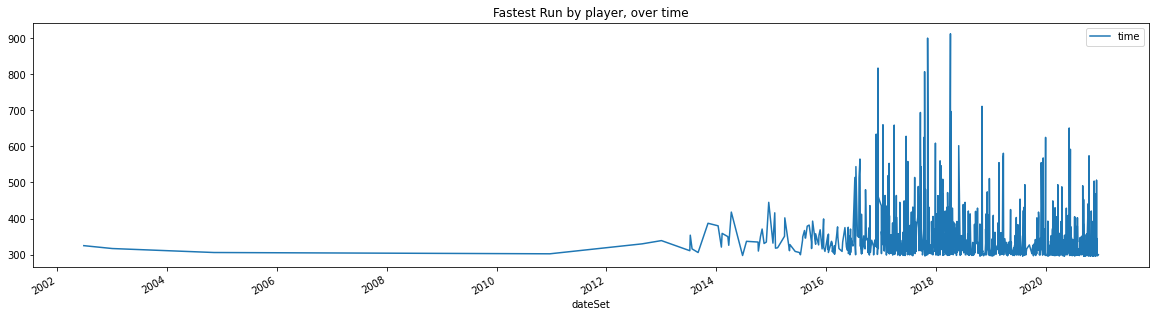

In [7]:
df.plot.line(x='dateSet', y='time', title="Fastest Run by player, over time", figsize=(20,5))

Okay, clearly as more people started speedrunning around 2014, the variances between times skyrockets as well. Remember, the data only shows the *best* run for every player. Another factor for the noise in recent years is that for a given Player, it is more likely that their fastest time came in recent years. We can confirm this by bucketing the number of runs per year.

<AxesSubplot:title={'center':'When runs were set, from 2002 to 2020'}, ylabel='Frequency'>

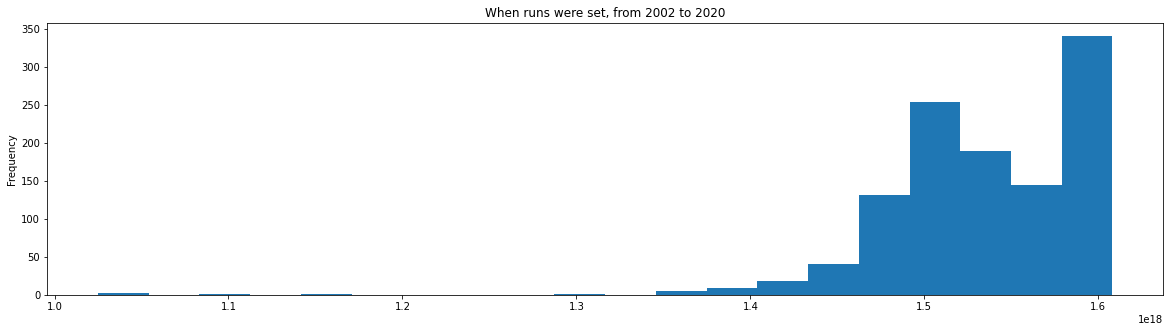

In [8]:
df['dateSet'].astype(np.int64).plot.hist(bins=20, title='When runs were set, from 2002 to 2020', figsize=(20,5))

Looking back at the "Fastest runs by player over time" graph, it seems like there is a lower bound within all the noise. Lets try to plot that lower bounds, bucketing times by month.

<AxesSubplot:title={'center':'Fastest Run per Month'}, xlabel='monthSet'>

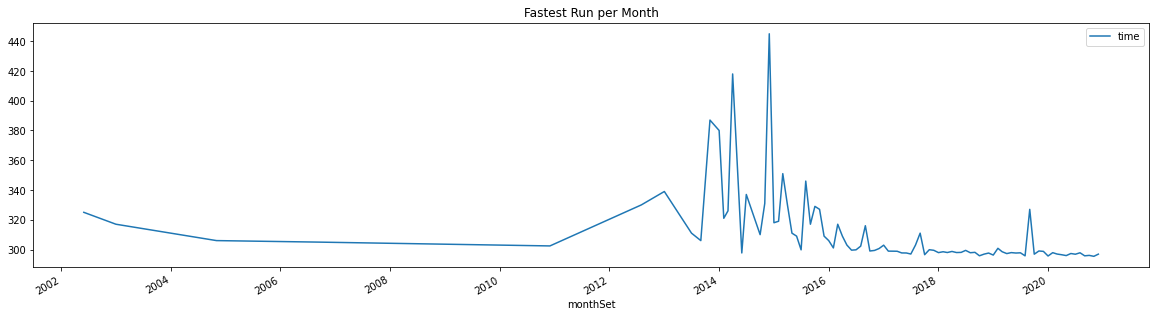

In [9]:
groupedRuns = df
groupedRuns['monthSet'] = groupedRuns.apply(lambda row: row['dateSet'].replace(day=1), axis=1)
groupedRuns = groupedRuns.groupby(by=df['monthSet']).min()
groupedRuns['time']

groupedRuns.plot.line(y='time', title="Fastest Run per Month", figsize=(20,5))

Wow. In late 2014 there was a month where nobody broke the 7 minute mark? Bucketing by any larger granularity will likely lose the context of what we are trying to find, so lets start analyzing the data by something new: just the times, not the dates.

We will filter down to runs under 6 minutes. Recall, we are looking for strategies that save small amounts of time as the world record has reached its limit.

In [10]:
times = df[['Player', 'dateSet', 'time']].sort_values(by='time', ascending=False)
times = times[times['time'] < 360].reset_index(drop=True)
times

,Player,dateSet,time
0,FabianUnkreativ,2020-06-09,359.000
1,Shark_Eat_Fish,2020-04-03,359.000
2,Jaybug,2018-04-10,359.000
3,DownHaul,2018-02-16,359.000
4,Zehal,2014-02-09,359.000
...,...,...,...
909,somewes,2018-10-22,295.796
910,eddiecatgaming,2020-09-21,295.763
911,tavenwebb2002,2019-08-02,295.746
912,Kosmic,2020-01-17,295.646


<AxesSubplot:title={'center':'Runs under 6 Minutes'}>

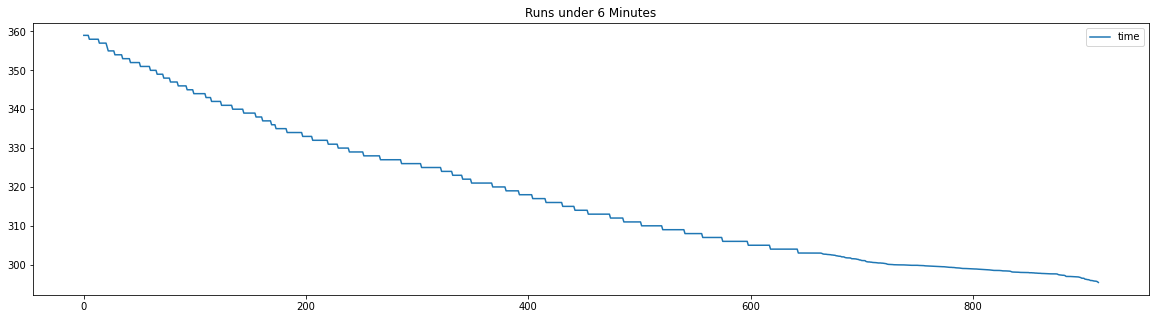

In [11]:
times.plot.line(y='time', figsize=(20,5), title='Runs under 6 Minutes')

Let's look for windows that have the highest standard deviation... basically looking for windows where the differences between higher times and lower times is large.

<AxesSubplot:title={'center':'Standard Deviations of run time in a 5 run window'}>

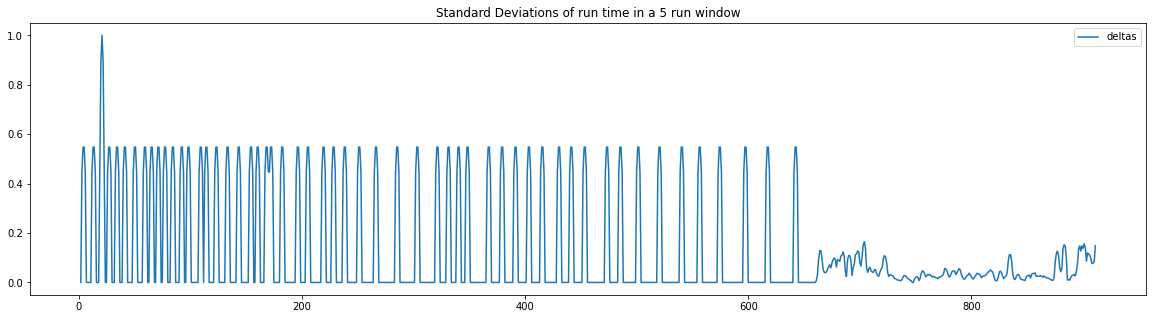

In [12]:
times['deltas'] = times['time'].rolling(5, center=True).std()
times.plot.line(y='deltas', figsize=(20,5), title='Standard Deviations of run time in a 5 run window')

I'd image the wave nature of the deltas of runs 0-650 is because the times were only tracked to the second, not the millisecond. Let's look at the more precise data.

<AxesSubplot:title={'center':'Standard Deviations of run time in a 5 run window (on millisecond granularity)'}>

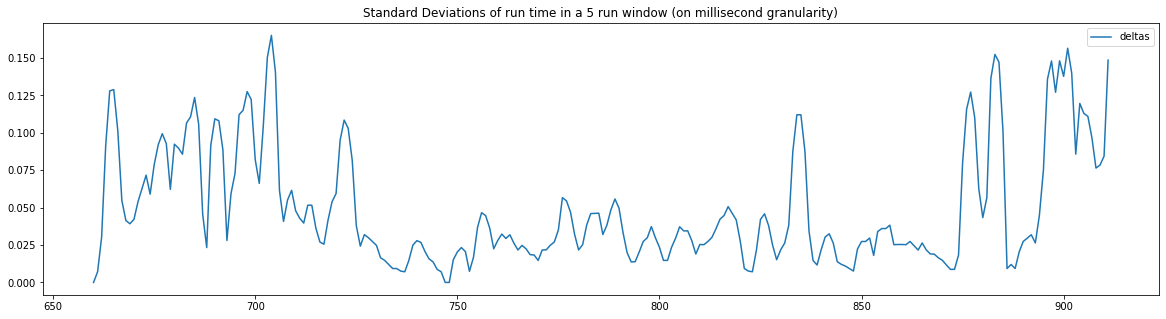

In [13]:
deltasAndDates = times[['dateSet', 'deltas', 'Player']][660:]
deltasAndDates.plot.line(y='deltas', figsize=(20,5), title='Standard Deviations of run time in a 5 run window (on millisecond granularity)')

Nice! Now let's go get the largest 10 (and ties)

In [14]:
deltasAndDates.nlargest(10, 'deltas', keep='all').sort_values(by='dateSet', ascending=True)

,dateSet,deltas,Player
705,2017-04-02,0.140507,LK
897,2019-01-11,0.148057,AndrewG
901,2019-01-12,0.156548,RoyLT
704,2019-02-05,0.165169,selflessscoundrel
911,2019-08-02,0.148564,tavenwebb2002
703,2020-02-24,0.150463,baXschi
902,2020-05-06,0.139880,Lul_ecks_dee
884,2020-10-11,0.147263,Alvaca
899,2020-11-14,0.148158,scalpel
883,2020-12-12,0.152429,AdamFerrari64


There we go! The top 10 biggest jumps in speedrunning Super Mario Bros. Now we get to see if this analysis was even remotely accurate. Time to go watch SummoningSalt's history of SMB speedruns: [https://www.youtube.com/watch?v=RdAkY7RfajY&t=703s]

Yeaaaahhh nevermind. Turns out that video is 3 years old, and most of the notable new strategies found for the game were found in the AndrewG era of dominance before 2014. And because I'm not quite up for browing the Speedrunning forums for days to figure out if my recent data was right, I guess I'll leave it there.